# ChromVAR

Run ChromVAR manually.

In [2]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
set.seed(2020)

In [3]:
register(MulticoreParam(20, progressbar = TRUE))

In [ ]:
# PFM_DIR = './data/neurallike_modisco/'
PFM_DIR = '../20200702_modisco_summarize/data/20200518_n76052/svm/50k/cluster_idx10/pfms/'
PFM_FILES = list.files(PFM_DIR)
PFM_NAMES = lapply(strsplit(PFM_FILES, "\\."), "[[", 1)
PFM_FILES = paste(PFM_DIR, PFM_FILES, sep='')
PFM_NAMES
PFM_FILES

In [ ]:
get_rev_comp <- function(motif_pfm) {
    motif_pfm = motif_pfm[, rev(seq(1,ncol(motif_pfm)))]
    
    stopifnot(rownames(motif_pfm)==c("A","C","G","T"))
    rownames(motif_pfm) = c("T", "G", "C", "A")
    
    motif_pfm = motif_pfm[c("A","C","G","T"), ]
}

load_motif <- function(pfm_path, max_width=20) {
    stopifnot(max_width%%2==0)
    
    # loads motif in a canonical form such that A,C are maximised
    motif_pfm = t(as.matrix(read.table(pfm_path)))
    rownames(motif_pfm) = c("A", "C", "G", "T")
    
    if (ncol(motif_pfm)>max_width) {
        # roughly estimate "center of mass"
        center = as.integer(sum(colMaxs(motif_pfm)*seq(1,ncol(motif_pfm)))/sum(colMaxs(motif_pfm)))
        start = center - (max_width/2)
        end = center + (max_width/2) - 1
        
        if (start < 1) {
            start = 1
            end = max_width
        }
        
        else if (end > ncol(motif_pfm)) {
            end = ncol(motif_pfm)
            start = end - max_width + 1
        }
        
        motif_pfm = motif_pfm[, start:end]
    }
    
    rev_comp_pfm = get_rev_comp(motif_pfm)
    
    # canonicalize (A/C content in first half of motif)
    if (sum(rev_comp_pfm[c("A","C"),1:floor(ncol(rev_comp_pfm)/2)])>sum(motif_pfm[c("A","C"),1:floor(ncol(motif_pfm)/2)])) {
        motif_pfm = rev_comp_pfm
    }
    
    motif_pfm
}

In [ ]:
MAX_MOTIF_LEN = 30
pfms = list()

for (i in seq(length(PFM_FILES))) {
    cur_pfm = load_motif(PFM_FILES[i])
    pfms[[i]] = PFMatrix(ID=unlist(PFM_NAMES[i]),
                        name=unlist(PFM_NAMES[i]),
                        bg=c(A=0.25, C=0.25, G=0.25, T=0.25),
                        profileMatrix=cur_pfm)
}

In [ ]:
motifs = do.call(PFMatrixList, c(pfms, use.names=T))
motifs

In [ ]:
pfms[[1]]@ID

In [ ]:
to_plot = lapply(pfms, as.matrix)
names(to_plot) = lapply(pfms, function(x) {x@ID})

In [ ]:
names(to_plot)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggseqlogo(to_plot, ncol=3) +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(),
         axis.title.y = element_blank())

In [ ]:
dim(get_rev_comp(to_plot[[2]]))

In [ ]:
# options(repr.plot.width = 10, repr.plot.height = 5)
# ggseqlogo(list(to_plot[[2]][,19:33], get_rev_comp(to_plot[[13]])[,16:30]), ncol=1) +
# theme(axis.text.x = element_blank(),
#          axis.text.y = element_blank(),
#          axis.title.y = element_blank(),plot.title=element_blank())

In [ ]:
motif_names = c()
for (i in seq(length(motifs))) {
    motif_names = c(motif_names, name(motifs[[i]]))
}
motif_names

### Or Load Precomputed Peaks x Motif Hits Matrix

In [4]:
motifs_bpnet_hits = readMM("../20200723_motif_annotation/bpnet_scores/20201020_n62402/peaks.overlap.hits.bpnet.no_iPSC.FDR_0.1.mm")

In [5]:
dim(motifs_bpnet_hits)

[1] 414473    123

In [6]:
motif_bpnet_hits_names = read.table("../20200723_motif_annotation/bpnet_scores/20201020_n62402//peaks.overlap.hits.bpnet.no_iPSC.FDR_0.1.motif.names.txt")
motif_bpnet_hits_names = as.character(unlist(motif_bpnet_hits_names$V1))

In [7]:
length(motif_bpnet_hits_names)

[1] 123

In [8]:
motif_bpnet_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = motifs_bpnet_hits), 
                 colData = DataFrame(name=motif_bpnet_hits_names)
    );

## Load Data

In [9]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [11]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5,D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5,D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5,D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5,D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5,D0_ACTCGCTACTTGTGAC


In [13]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 414473      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10268_10885,chr1,10268,10885,chr1_10268_10885
chr1_41988_42505,chr1,41988,42505,chr1_41988_42505
chr1_46058_46558,chr1,46058,46558,chr1_46058_46558
chr1_48200_48959,chr1,48200,48959,chr1_48200_48959
chr1_51306_52190,chr1,51306,52190,chr1_51306_52190
chr1_58644_59144,chr1,58644,59144,chr1_58644_59144


In [14]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 414473 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10268-10885      *
       [2]     chr1       41988-42505      *
       [3]     chr1       46058-46558      *
       [4]     chr1       48200-48959      *
       [5]     chr1       51306-52190      *
       ...      ...               ...    ...
  [414469]     chrY 25399010-25399553      *
  [414470]     chrY 25410561-25411061      *
  [414471]     chrY 26220958-26221458      *
  [414472]     chrY 26315008-26315508      *
  [414473]     chrY 26670870-26671408      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [15]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [16]:
pmatRowSums = Matrix::rowSums(pmat)

In [17]:
pmatColSums = Matrix::colSums(pmat)

In [18]:
min(pmatRowSums)

[1] 222

In [19]:
min(pmatColSums)

[1] 15

## ChromVAR

In [20]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [21]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [22]:
rse <- addGCBias(rse, genome = GENOME);

---
Match motifs

In [ ]:
# motif_mm <- matchMotifs(motifs, rse, genome = GENOME)

Or use pre-computed matrix, e.g. from BPNet hits loaded above

In [23]:
motif_mm <- motif_bpnet_hits_se

---

In [24]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_mm$name

In [25]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



In [26]:
dev_mat = t(assay(dev))

In [28]:
colnames(dev_mat) = motif_mm$name
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,AP2A_HUMAN.H11MO.0.A,AP2A_MOUSE.H11MO.0.A,AP2C_HUMAN.H11MO.0.A,Ascl2.mouse_bHLH_1,ATF1_MOUSE.H11MO.0.B,BATF+JUN_MA0462.1,CEBPA_MA0102.3,CEBPB_MOUSE.H11MO.0.A,CREB1_MA0018.3,CREB3_bZIP_1,⋯,VEZF1_HUMAN.H11MO.0.C,YY1_MA0095.2,ZBTB18_MA0698.1,ZBTB33_MA0527.1,ZFX_MOUSE.H11MO.0.B,ZN143_HUMAN.H11MO.0.A,ZN143_MOUSE.H11MO.0.A,ZNF238_C2H2_1,ZNF238_C2H2_2,ZNF76_HUMAN.H11MO.0.C
D0_AACGCGAGAAGGACCA,-0.12294065,-0.09352625,-0.10794921,0.08798450,0.018353336,0.03361392,0.34264057,0.22410861,0.12877157,0.10686871,⋯,-0.05705881,-0.035062317,0.0654240384,-0.003564588,-0.03832660,-0.03587245,-0.03941892,0.04882215,0.0654240384,-0.06306453
D0_AACGCGCTGTCTGTGA,-0.12821733,-0.09127279,-0.11971037,-0.05039826,-0.165470322,0.17952061,-0.06281021,-0.08282114,0.12301088,0.12257224,⋯,-0.05607968,-0.068237933,-0.0634596941,0.032931037,-0.04811726,-0.02580824,-0.02821128,-0.04213231,-0.0634596941,-0.06673984
D0_ACCTATGGACTCGATA,-0.09000103,-0.07525123,-0.05044384,0.02199156,0.064826831,0.16002619,0.17504433,0.16178425,-0.01575793,-0.04535254,⋯,-0.04363534,-0.032693962,0.0083265061,-0.079405863,-0.01814928,-0.03548759,-0.01061891,0.03299011,0.0083265061,-0.03533180
D0_ACGCAGAGATAACCCA,-0.13996900,-0.11293790,-0.12036074,0.03213452,0.007410609,0.10376001,0.06106466,0.04992117,0.10107298,0.08227665,⋯,-0.06270160,-0.157120673,0.0279788745,-0.047696751,-0.04599367,-0.09518446,-0.09121124,0.05588418,0.0279788745,-0.05976590
D0_ACTCGCTACTTGTGAC,-0.29016466,-0.26960139,-0.26274589,-0.08115598,0.169576565,0.17302266,0.05314971,0.21316328,0.08961263,0.11566191,⋯,-0.11856937,0.002780547,-0.2417367283,0.138115475,-0.13441524,-0.10250958,-0.17400573,-0.25518424,-0.2417367283,-0.14147841
D0_AGACTACTGGCAGTTT,-0.05789882,-0.03753335,-0.03960972,0.07398756,0.126405154,0.12559693,0.39322449,0.30191576,0.07435968,0.10389412,⋯,-0.02603083,-0.093000115,0.0005260283,-0.059059651,-0.01943282,-0.04448186,-0.02886792,0.02527477,0.0005260283,-0.04497569


In [100]:
# save output
# write.table(dev_mat, file="./out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv", quote=F, row.names=T, sep='\t')

In [29]:
variability <- computeVariability(dev)

  |======================================================================| 100%



In [30]:
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AP2A_HUMAN.H11MO.0.A,4.490368,4.460568,4.521316,0.000000e+00,0.000000e+00
2,AP2A_MOUSE.H11MO.0.A,4.219412,4.189589,4.247578,0.000000e+00,0.000000e+00
3,AP2C_HUMAN.H11MO.0.A,4.249830,4.221942,4.279372,0.000000e+00,0.000000e+00
4,Ascl2.mouse_bHLH_1,1.443382,1.433067,1.453731,0.000000e+00,0.000000e+00
5,ATF1_MOUSE.H11MO.0.B,1.037049,1.030474,1.043405,5.718109e-34,5.718109e-34
6,BATF+JUN_MA0462.1,7.194648,7.151433,7.236768,0.000000e+00,0.000000e+00


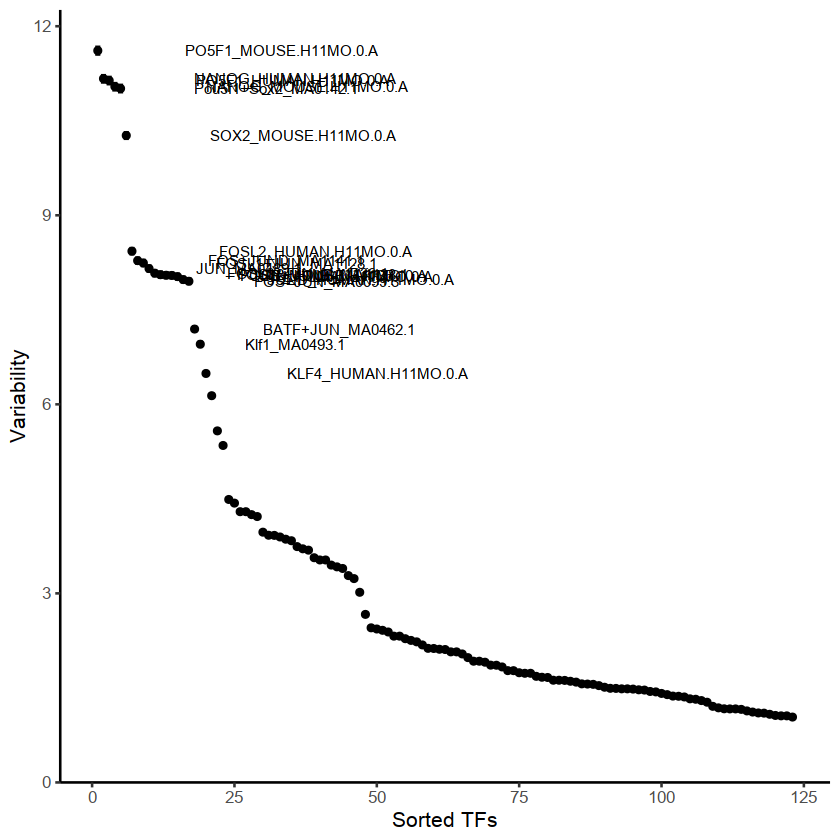

In [31]:
plotVariability(variability, use_plotly = FALSE, n = 20) 

In [117]:
variability[rev(order(variability$variability)), "name"][45:55]

[1] RUNX1_MOUSE.H11MO.0.A  FOXL2_MOUSE.H11MO.0.C  RUNX1_MA0002.2        
 [4] RUNX2_MOUSE.H11MO.0.A  ZNF76_HUMAN.H11MO.0.C  TAF1_HUMAN.H11MO.0.A  
 [7] Foxc1.mouse_forkhead_2 ZFX_MOUSE.H11MO.0.B    FOXC2_MA0846.1        
[10] FOXC2_forkhead_3       TWST1_HUMAN.H11MO.0.A 
123 Levels: AP2A_HUMAN.H11MO.0.A AP2A_MOUSE.H11MO.0.A ... ZNF76_HUMAN.H11MO.0.C

In [32]:
variability[rev(order(variability$variability)), "name"]

[1] PO5F1_MOUSE.H11MO.0.A  NANOG_HUMAN.H11MO.0.A  PO5F1_HUMAN.H11MO.0.A 
  [4] NANOG_MOUSE.H11MO.0.A  Pou5f1+Sox2_MA0142.1   SOX2_MOUSE.H11MO.0.A  
  [7] FOSL2_HUMAN.H11MO.0.A  FOS+JUND_MA1141.1      FOSL1+JUN_MA1128.1    
 [10] JUN_MA0489.1           FOSL2+JUN_MA1130.1     FOSL2+JUNB_MA1138.1   
 [13] FOSB+JUNB_MA1135.1     JUN_MOUSE.H11MO.0.A    JUN_HUMAN.H11MO.0.A   
 [16] JUND_HUMAN.H11MO.0.A   FOS+JUN_MA0099.3       BATF+JUN_MA0462.1     
 [19] Klf1_MA0493.1          KLF4_HUMAN.H11MO.0.A   KLF5_MA0599.1         
 [22] KLF9_MA1107.1          KLF3_HUMAN.H11MO.0.B   AP2A_HUMAN.H11MO.0.A  
 [25] SP2_MA0516.1           SP3_MOUSE.H11MO.0.B    SP3_HUMAN.H11MO.0.B   
 [28] AP2C_HUMAN.H11MO.0.A   AP2A_MOUSE.H11MO.0.A   SP1_HUMAN.H11MO.0.A   
 [31] CTCFL_MOUSE.H11MO.0.A  CTCFL_HUMAN.H11MO.0.A  CTCF_MA0139.1         
 [34] CTCF_MOUSE.H11MO.0.A   CTCF_HUMAN.H11MO.0.A   SP5_MOUSE.H11MO.0.C   
 [37] MAZ_HUMAN.H11MO.0.A    Sox3_MA0514.1          RUNX1_HUMAN.H11MO.0.A 
 [40] SP2_MOUSE.H11MO.0.B    SP2_HUMAN.H11MO.0.A    VEZF1_HUMAN.H11MO.0.C 
 [43] SP1_MOUSE.H11MO.0.A    RUNX3_HUMAN.H11MO.0.A  RUNX1_MOUSE.H11MO.0.A 
 [46] FOXL2_MOUSE.H11MO.0.C  RUNX1_MA0002.2         RUNX2_MOUSE.H11MO.0.A 
 [49] ZNF76_HUMAN.H11MO.0.C  TAF1_HUMAN.H11MO.0.A   Foxc1.mouse_forkhead_2
 [52] ZFX_MOUSE.H11MO.0.B    FOXC2_MA0846.1         FOXC2_forkhead_3      
 [55] TWST1_HUMAN.H11MO.0.A  TWST1_MOUSE.H11MO.0.B  ETV2_HUMAN.H11MO.0.B  
 [58] TAF1_MOUSE.H11MO.0.A   ETS1_MOUSE.H11MO.0.A   ZNF238_C2H2_1         
 [61] FLI1_MOUSE.H11MO.0.A   ERG_MOUSE.H11MO.0.A    ZNF238_C2H2_2         
 [64] ZBTB18_MA0698.1        ETS1_HUMAN.H11MO.0.A   CEBPA_MA0102.3        
 [67] TEAD3_TEA_2            TEAD3_MA0808.1         TWIST1_MA1123.1       
 [70] ELK4_MA0076.2          ZN143_MOUSE.H11MO.0.A  ZN143_HUMAN.H11MO.0.A 
 [73] NFIA_HUMAN.H11MO.0.C   ETV1_HUMAN.H11MO.0.A   CEBPB_MOUSE.H11MO.0.A 
 [76] RFX1_MOUSE.H11MO.0.A   RFX1_HUMAN.H11MO.0.B   Gabpa_MA0062.2        
 [79] TEAD4_HUMAN.H11MO.0.A  THA11_HUMAN.H11MO.0.B  JDP2_MA0656.1         
 [82] JDP2_bZIP_4            TEAD1_HUMAN.H11MO.0.A  TEAD4_MOUSE.H11MO.0.A 
 [85] NFIC_HUMAN.H11MO.0.A   CREB1_MA0018.3         THA11_MOUSE.H11MO.0.B 
 [88] TYY1_HUMAN.H11MO.0.A   NRF1_MA0506.1          NRF1_MOUSE.H11MO.0.A  
 [91] NFYC_HUMAN.H11MO.0.A   CREB3_bZIP_1           NFYB_MOUSE.H11MO.0.A  
 [94] NFYB_HUMAN.H11MO.0.A   NFYC_MOUSE.H11MO.0.B   TYY1_MOUSE.H11MO.0.A  
 [97] RFX2_MOUSE.H11MO.0.A   Ascl2.mouse_bHLH_1     NFIB_MOUSE.H11MO.0.C  
[100] YY1_MA0095.2           NRF1_HUMAN.H11MO.0.A   PRDM6_HUMAN.H11MO.0.C 
[103] REST_HUMAN.H11MO.0.A   REST_MA0138.2          NRF1_NRF_1            
[106] MSC_MA0665.1           REST_MOUSE.H11MO.0.A   TEAD3_TEA_1           
[109] RFX3_MOUSE.H11MO.0.C   Rfx1_MA0509.1          IRF1_MA0050.2         
[112] KAISO_MOUSE.H11MO.0.B  KAISO_HUMAN.H11MO.0.A  IRF1_MOUSE.H11MO.0.A  
[115] ZBTB33_MA0527.1        SIX2_HUMAN.H11MO.0.A   SIX1_HUMAN.H11MO.0.A  
[118] SIX2_MOUSE.H11MO.0.A   MYC_HUMAN.H11MO.0.A    RFX2_HUMAN.H11MO.0.A  
[121] USF2_MOUSE.H11MO.0.A   USF2_HUMAN.H11MO.0.A   ATF1_MOUSE.H11MO.0.B  
123 Levels: AP2A_HUMAN.H11MO.0.A AP2A_MOUSE.H11MO.0.A ... ZNF76_HUMAN.H11MO.0.C

In [136]:
cur_pattern = "ELK4_MA0076.2"

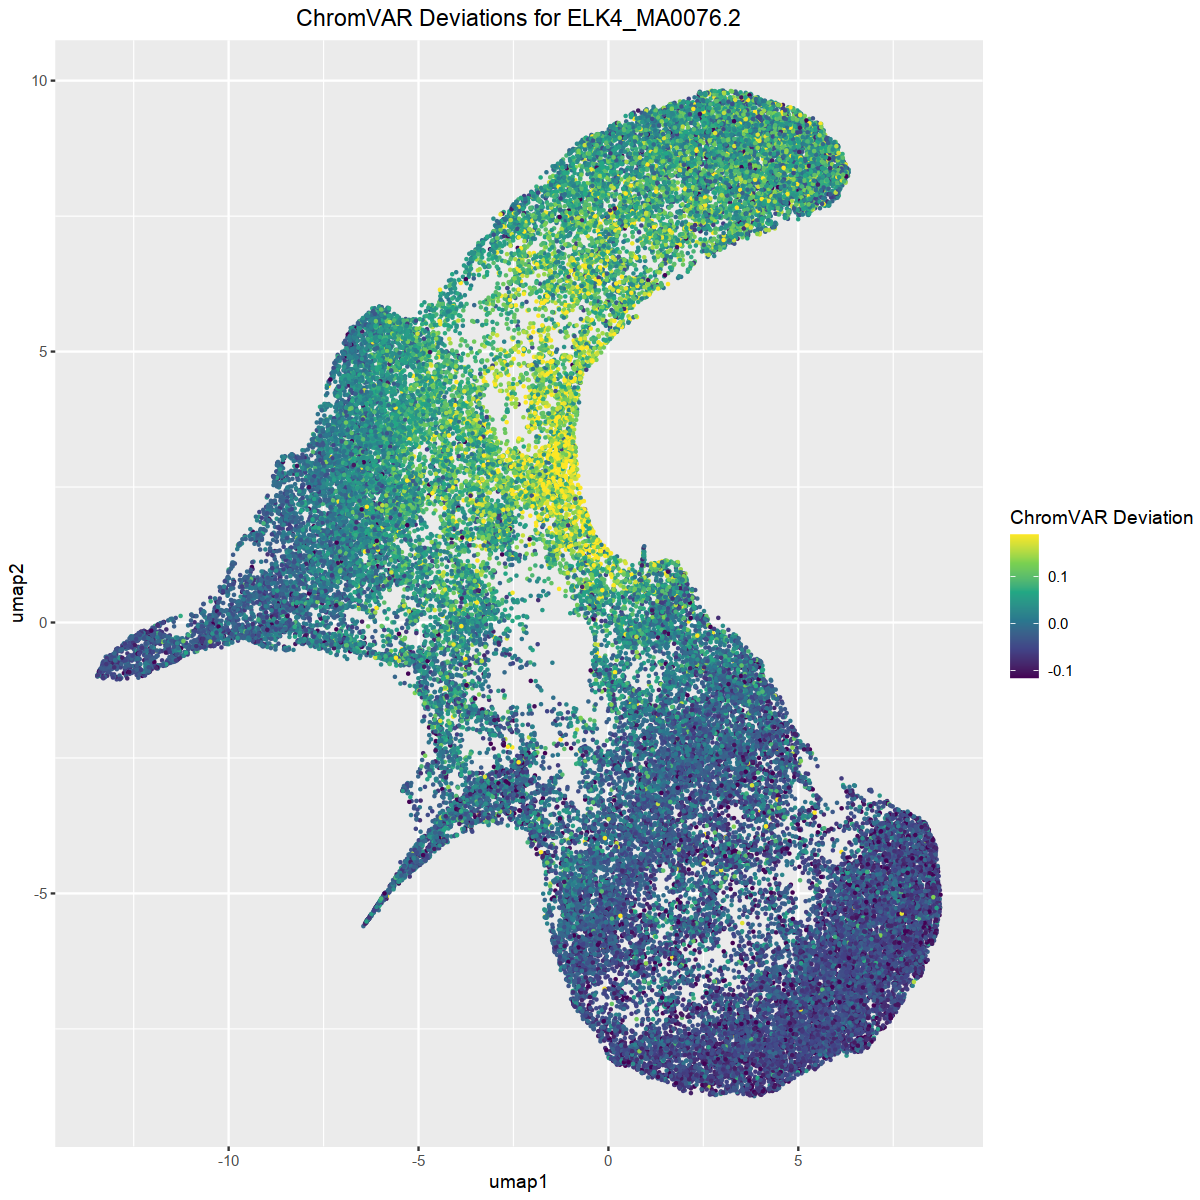

In [137]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.02),
                              quantile(cur_dev, 0.98)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) 

In [120]:
sum(motif_mm_mat[, cur_pattern])

[1] 4643

In [121]:
frip = 100*Matrix::rowSums(pmat[, motif_mm_mat[, cur_pattern]])/pmatRowSums

In [122]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.4864593

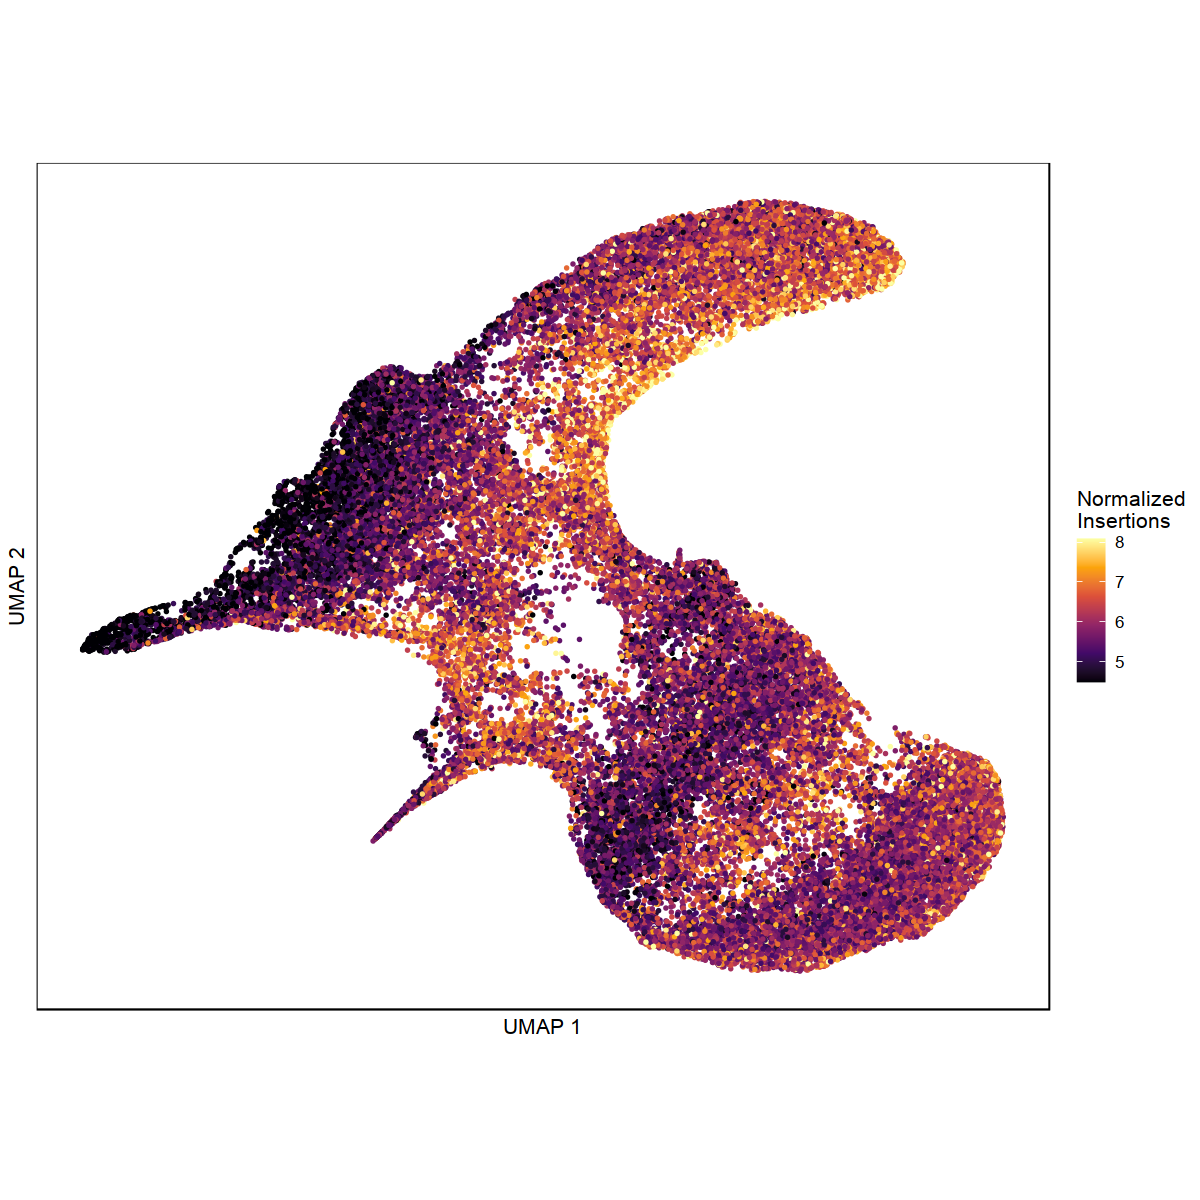

In [123]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.05),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

### SessionInfo

In [236]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.0                      ggplot2_3.3.0                    
 [3] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [5] DelayedArray_0.12.3               BiocParallel_1.20.1              
 [7] matrixStats_0.56.0                Biobase_2.46.0   